In [1]:
using Distributions
using LinearAlgebra
using Plots
using DataFrames
using CSV
include("../experiments/cartpole-beta.jl")
;

load done: 20.013


In [126]:
DUMP_DIR = joinpath(@__DIR__, "..", "dump", "random-beta")

colors = palette(:tab10)
;

In [127]:
function loadDataFrame(dim)
    basename = "randw40_dim$(dim).csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadBounds()
    csv1 = loadDataFrame(1)
    csv2 = loadDataFrame(2)
    csv3 = loadDataFrame(3)
    csv4 = loadDataFrame(4) 
    
    x1mins, x1maxs = -1*csv1.neg_val, csv1.pos_val
    x2mins, x2maxs = -1*csv2.neg_val, csv2.pos_val
    x3mins, x3maxs = -1*csv3.neg_val, csv3.pos_val
    x4mins, x4maxs = -1*csv4.neg_val, csv4.pos_val
    
    x1s = [x1mins x1maxs]
    x2s = [x2mins x2maxs]
    x3s = [x3mins x3maxs]
    x4s = [x4mins x4maxs]
    
    return x1s, x2s, x3s, x4s
end

function loadEllipsoidDataFrame()
    basename = "randw40_ellipsoid.csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadEllipsoids()
    csv = loadEllipsoidDataFrame()
    
    ellipsoids = Vector{Any}()
    for row in csv
        yc = Vector{Real}([row[:yc1]; row[:yc2]; row[:yc3]; row[:yc4]])
        P = Matrix{Real}([
            row[:P11] row[:P12] row[:P13] row[:P14];
            row[:P12] row[:P22] row[:P23] row[:P24];
            row[:P13] row[:P23] row[:P33] row[:P34];
            row[:P14] row[:P24] row[:P34] row[:P44]
        ])
        push!(ellipsoids, (P, yc))
    end
    return ellipsoids
end

x1s, x2s, x3s, x4s = loadBounds()
ellipsoids = loadEllipsoids()
;

In [128]:
ellipsoids

11-element Vector{Any}:
 (Real[985.8721922353446 -91.73390761459973 -103.11375177380849 -661.6556757983429; -91.73390761459973 1370.0308201165728 123.55215349676989 -237.5478384874148; -103.11375177380849 123.55215349676989 594.0685352331017 127.45426691337599; -661.6556757983429 -237.5478384874148 127.45426691337599 1778.280592322208], Real[-37.42178691983514, 4.137037965337878, -4.417952671981464, 27.66448231402844])
 (Real[796.8197634848764 -73.00411211186758 -81.93249934377525 -536.1446714125998; -73.00411211186758 1104.8084086013869 98.05047385172817 -190.53182859695843; -81.93249934377525 98.05047385172817 478.579247871717 101.22409221973685; -536.1446714125998 -190.53182859695843 101.22409221973685 1433.3147517898026], Real[-37.37982396526979, 4.112728477928395, -4.4488741258725515, 27.57960183370061])
 (Real[697.5133568618791 -62.956828731922855 -71.6467328857256 -468.5752838846648; -62.956828731922855 975.2371843114411 86.68316935579861 -172.95013394041754; -71.6467328857256 8

In [129]:
[x1s x2s]

11×4 Matrix{Float64}:
 -294.789  190.808   -306.277  341.144
 -294.789  179.382   -306.277  341.144
 -294.789  131.693   -287.401  308.259
 -294.789  100.743   -232.926  258.223
 -294.789   86.2712  -198.958  230.298
 -293.948   75.1042  -183.241  216.164
 -278.557   67.6852  -154.63   204.343
 -269.09    66.1734  -145.78   198.037
 -254.569   64.4823  -135.575  190.351
 -236.192   62.0752  -126.186  184.392
 -226.315   59.9148  -115.985  179.992

In [130]:
[x3s x4s]

11×4 Matrix{Float64}:
 -188.624  184.751   -375.394  476.45
 -188.624  184.751   -367.38   476.45
 -188.624  184.751   -326.376  476.45
 -156.955  171.572   -300.839  434.489
 -144.168  156.196   -275.044  404.373
 -130.031  143.356   -251.782  383.973
 -120.552  132.566   -231.28   344.871
 -114.02   121.035   -214.283  319.066
 -105.791  109.147   -206.764  299.784
 -101.023  101.917   -197.923  280.792
 -100.301   95.7645  -183.539  264.002

In [143]:
function plotBox2D!(plt, xa, xb, ya, yb; kwargs...)
    verts = Vector{VecReal}()
    push!(verts, [xa; ya])
    push!(verts, [xa; yb])
    push!(verts, [xb; yb])
    push!(verts, [xb; ya])
    push!(verts, verts[1])
    
    plt = Utils.plotSeq2DPoints!(plt, verts; kwargs...)
    return plt
end

function plotBoxes!(plt, xmins, xmaxs, ymins, ymaxs; kwargs...)
    @assert length(xmins) == length(xmaxs) == length(ymins) == length(ymaxs)
    num_points = length(xmins)
    points = [(xmins[i], xmaxs[i], ymins[i], ymaxs[i]) for i in 1:num_points]
    for (xa, xb, ya, yb) in points
        plt = plotBox2D!(plt, xa, xb, ya, yb; linestyle=:solid, linedwith=2, kwargs...)
    end
    return plt
end

# Plot the boundary of a 2D ellipse: {y = Px + yc : ||x||^2 = 1}
function plotEllipse!(plt, P, yc; kwargs...)
  @assert size(P) == (2, 2)
  @assert length(yc) == 2
  c(t) = P * [cos(t); sin(t)] + yc
  c1(t) = c(t)[1]
  c2(t) = c(t)[2]
  ts = range(0, stop=2*π, length=10000)
  plt = plot!(plt, c1.(ts), c2.(ts); kwargs...)
  # plt = plot!(plt, c1, c2, ts)
  return plt
end


plotEllipse! (generic function with 1 method)

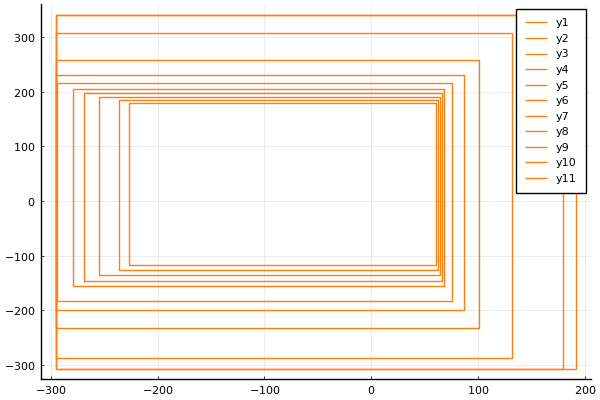

In [144]:
plt = plot()

inds = [1;5;6;11]

# todo_xs, todo_ys = x3s[inds,:], x4s[inds,:]

todo_xs, todo_ys = x1s, x2s

plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2], color=colors[2])

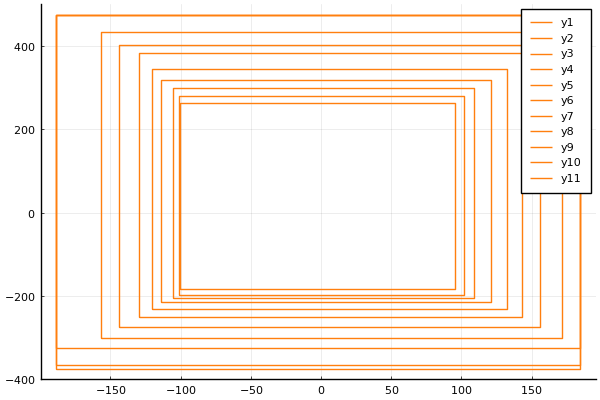

In [145]:
plt = plot()

# inds = [1;5;20;40]

# todo_xs, todo_ys = x3s[inds,:], x4s[inds,:]

todo_xs, todo_ys = x3s, x4s

plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2], color=colors[2])

In [146]:
x3s

11×2 Matrix{Float64}:
 -188.624  184.751
 -188.624  184.751
 -188.624  184.751
 -156.955  171.572
 -144.168  156.196
 -130.031  143.356
 -120.552  132.566
 -114.02   121.035
 -105.791  109.147
 -101.023  101.917
 -100.301   95.7645

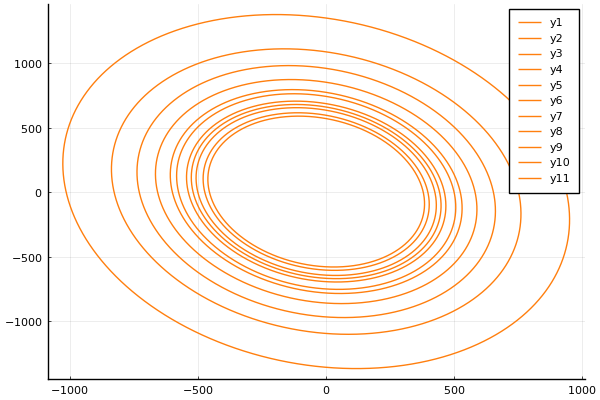

In [147]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[1:2, 1:2], yc[1:2]
    plotEllipse!(plt, Pp, ycp, color=colors[2])
end
plt

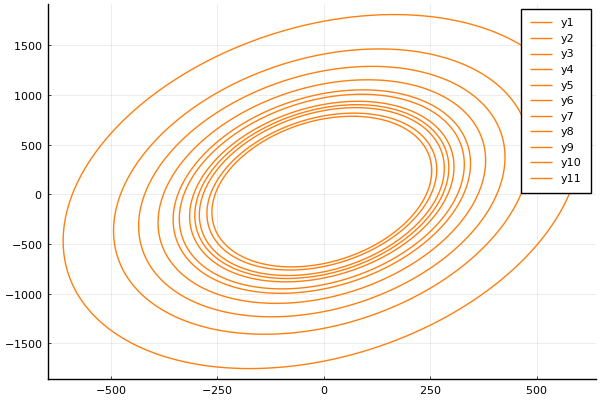

In [149]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[3:4, 3:4], yc[3:4]
    plotEllipse!(plt, Pp, ycp, color=colors[2])
end
plt

In [137]:
length(ellipsoids)

11

In [138]:
ellipsoids[1][1]

4×4 Matrix{Real}:
  985.872    -91.7339  -103.114  -661.656
  -91.7339  1370.03     123.552  -237.548
 -103.114    123.552    594.069   127.454
 -661.656   -237.548    127.454  1778.28

In [29]:
ellipsoids[10][1]

4×4 Matrix{Real}:
  2.449      0.103134  -1.26226   -0.745316
  0.103134   2.11051   -0.354309  -0.209192
 -1.26226   -0.354309   6.41843    2.56013
 -0.745316  -0.209192   2.56013    3.59342